# Homework 1:
### In this project, we will be analyzing the monthly page visits to different Wikipedia pages of dinosaurs, as listed in the dataset provided.

## Step 1: Setting up the API Call function which will allow us to pull in information about the required Wikipedia Page

* 1.1 Importing Libraries required for the API Call Function
* 1.2 Defining the Constants for the API Call, common for all access methods
* 1.3 Defining the API Call function, where the main inputs would be the Article Name and Access type


1.1 Importing Libraries required for the API Call Function

In [1]:
#1.1


import json, time, urllib.parse
import requests

1.2 Defining the Constants for the API Call, common for all access methods

In [2]:
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

 
REQUEST_HEADERS = {
    'User-Agent': '<reeyabp@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2022',
}



1.3 Defining the API Call function 

In [3]:
# Defining the API Call function 


def request_pageviews_per_article(article_title = None, 
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = None,
                                  headers = REQUEST_HEADERS):
    # Make sure we have an article title
    if not article_title: return None
    
    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(article_title.replace(' ','_'))
    request_template['article'] = article_title_encoded
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

## Step 2: Importing the Dataset of Articles using APIs, saving it as Json

* 2.1 Importing Libraries to for Importing data, Data Manipulation and Visualization
* 2.2 Using Pandas to import the CSV file containing the Article Names
* 2.3 Defining a function which can be used for all access methods
* 2.4 Updating the Paramaters to obtain the views accessed by Desktop, Mobile-web and Mobile-app

2.1 Importing Libraries to for Importing data, Data Manipulation and Visualization

In [4]:
import pandas as pd
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt



2.2 Using Pandas to import the CSV file containing the Article Names

In [5]:
dinosaurs = pd.read_csv('dinosaur_genera.cleaned.SEPT.2022 - dinosaur_genera.cleaned.SEPT.2022.csv')
dinosaurs['name']

0       "Coelosaurus" antiquus
1                Aachenosaurus
2                     Aardonyx
3                 Abdarainurus
4                 Abditosaurus
                 ...          
1418              Zuniceratops
1419                   Zuolong
1420                Zuoyunlong
1421               Zupaysaurus
1422                      Zuul
Name: name, Length: 1423, dtype: object

### 2.3 Defining a function which can be used for all access methods, to carry out the following methods:

* Input the required Access type
* Iterate through all the Dinosaur names to process the API call
* Iterate through each name to store all values except "access" type
* Save the output as Dictionary and Dataframe

In [6]:
def dino_to_json(accesstype):

    access_dict = []

    ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      accesstype,      # Selecting Desktop
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015010100",   # Setting the Start date to Jan 1, 2015
    "end":         "2022100100"    # Setting the End date to Oct 1, 2020
    }


    # Outer loop to iterate through all dinosaur names
    for dino in dinosaurs['name']:

        current_views = request_pageviews_per_article(article_title = dino, request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE)
    
        ## Middle loop to iterate through every API call of a dino

   

        for item in current_views['items']:

            current_dict = {k:v for k,v in item.items() if k in ["project","article","granularity","timestamp","agent","views"]}
                
            access_dict.append(current_dict)
            

    access_df = pd.DataFrame(access_dict)
    
    return access_dict, access_df

2.4 Updating the Paramaters to obtain the views accessed by Desktop, Mobile-web and Mobile-app

In [12]:
# Updating the Paramaters to obtain the views accessed by Desktop

desktop_dict, desktop_df = dino_to_json(accesstype = "desktop")

with open("dino_monthly_desktop_201501_202209.json", "w") as outfile:
    json.dump(desktop_dict, outfile, indent = 2)

In [7]:
# Updating the Paramaters to obtain the views accessed by mobile-app

mobapp_dict, mobapp_df = dino_to_json(accesstype = "mobile-app")

In [9]:
# Updating the Paramaters to obtain the views accessed by mobile-web


mobweb_dict, mobweb_df = dino_to_json(accesstype = "mobile-web")

In [13]:
## Adding the Mobile-app and Mobile-web views and creating a new DataFrame


mobile_df = mobapp_df.copy()
mobile_df['views'] = mobapp_df['views'] + mobweb_df['views']
mobile_df.head()

mobile_df.to_json("dino_monthly_mobile_201501_202209.json",orient='records',indent = 2)

## Step 3: Data Manipulation


* 3.1 Adding a new Dataframe called "total_df" which contains the total views of Desktop and Mobile
* 3.2 Adding a Date column to display Time Series data 

3.1 Adding a new Dataframe called "total_df" which contains the total views of Desktop and Mobile

In [14]:
total_df = desktop_df.copy()
total_df['views'] = mobile_df['views'] + total_df['views']

# Adding new column to include Cummulative Sum
total_df['cumsum'] =  total_df.groupby(['article'])['views'].cumsum()

total_df.to_json("dino_monthly_cumulative_201501_202209.json",orient='records',indent = 2)


3.2 Adding a Date column to display Time Series data 

In [15]:
desktop_df['date'] = pd.to_datetime(desktop_df['timestamp'], format = '%Y%m%d%H')
mobile_df['date'] = pd.to_datetime(mobile_df['timestamp'], format = '%Y%m%d%H')
total_df['date'] = pd.to_datetime(total_df['timestamp'], format = '%Y%m%d%H')

In [16]:
desktop_df.head()

,project,article,granularity,timestamp,agent,views,date
0,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2021110100,user,48,2021-11-01
1,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2021120100,user,151,2021-12-01
2,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2022010100,user,186,2022-01-01
3,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2022020100,user,161,2022-02-01
4,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2022030100,user,165,2022-03-01


In [17]:
mobile_df.head()

,project,article,granularity,timestamp,agent,views,date
0,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2021110100,user,5,2021-11-01
1,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2021120100,user,55,2021-12-01
2,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2022010100,user,51,2022-01-01
3,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2022020100,user,70,2022-02-01
4,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2022030100,user,54,2022-03-01


In [18]:
total_df.head()

,project,article,granularity,timestamp,agent,views,cumsum,date
0,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2021110100,user,53,53,2021-11-01
1,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2021120100,user,206,259,2021-12-01
2,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2022010100,user,237,496,2022-01-01
3,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2022020100,user,231,727,2022-02-01
4,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2022030100,user,219,946,2022-03-01


## Step 4: Analysis

##### Top 10 Peak Page Views Maximum Average and Minimum Average
The first graph should contain time series for the articles that have the highest average page requests and the lowest average page requests for desktop access and mobile access. Your graph should have four lines (max desktop, min desktop, max mobile, min mobile).

In [42]:
desktopmax = desktop_df.loc[desktop_df['article'] == desktop_df.groupby('article')['views'].mean().idxmax()]
desktopmin = desktop_df.loc[desktop_df['article'] == desktop_df.groupby('article')['views'].mean().idxmin()]
mobilemax = mobile_df.loc[mobile_df['article'] == mobile_df.groupby('article')['views'].mean().idxmax()]
mobilemin = mobile_df.loc[mobile_df['article'] == mobile_df.groupby('article')['views'].mean().idxmin()]

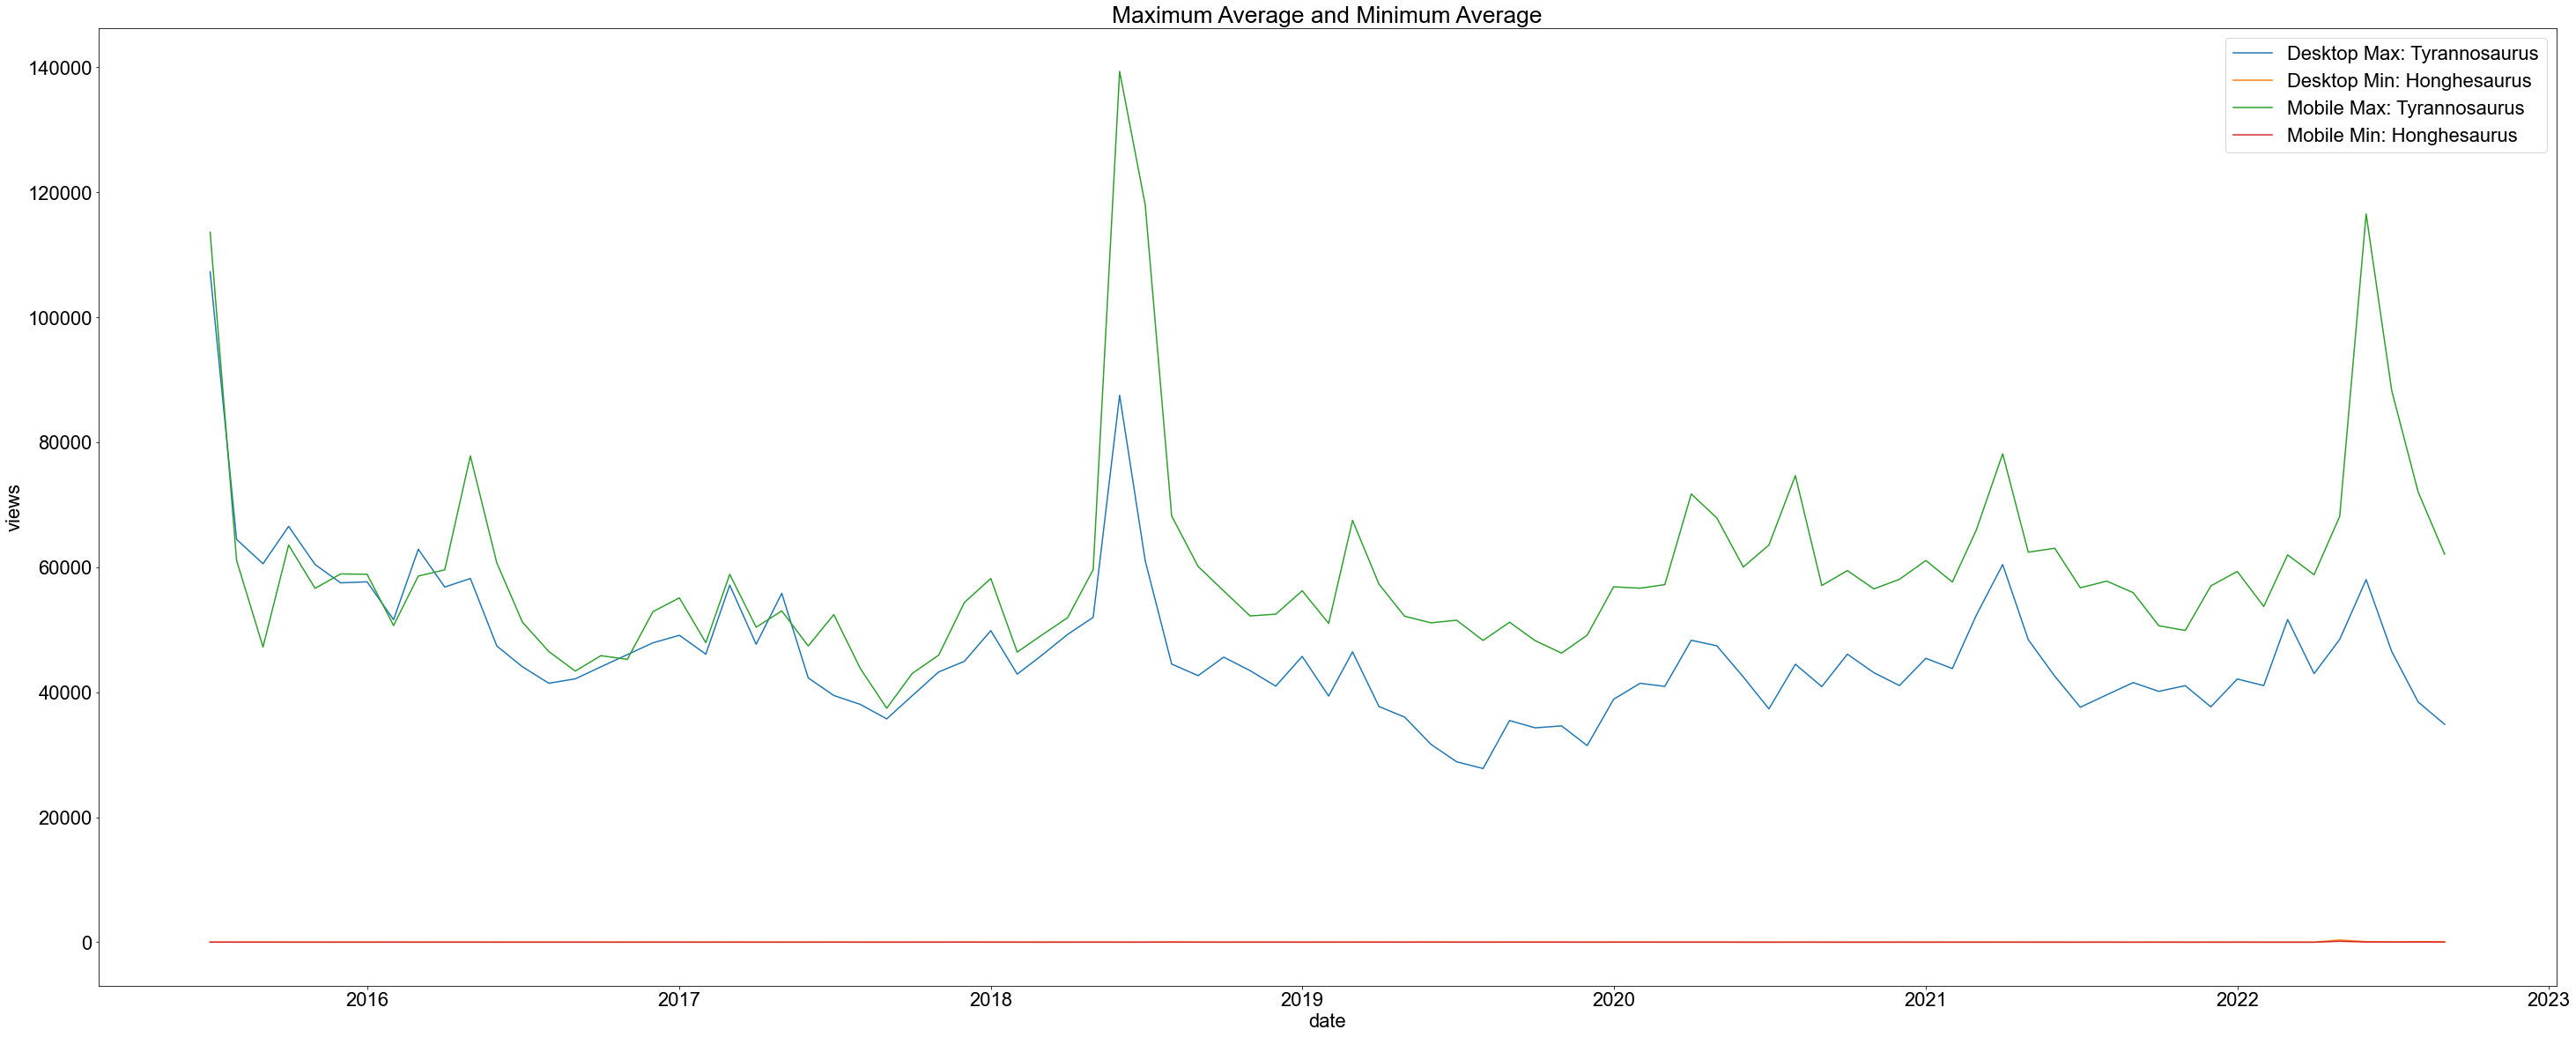

In [58]:
sns.lineplot(data = desktopmax, x = 'date', y='views')
sns.lineplot(data = desktopmin, x = 'date', y='views')
sns.lineplot(data = mobilemax , x = 'date', y='views')
sns.lineplot(data = mobilemin, x = 'date', y='views')
plt.legend(labels=['Desktop Max: Tyrannosaurus', 'Desktop Min: Honghesaurus', 'Mobile Max: Tyrannosaurus', 'Mobile Min: Honghesaurus'])
plt.title('Maximum Average and Minimum Average')
plt.rcParams.update({'font.size': 10})
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.savefig("./pic/Maximum Average and Minimum Average.png")

##### Top 10 Peak Page Views
The second graph should contain time series for the top 10 article pages by largest (peak) page views over the entire time by access type. You first find the month for each article that contains the highest (peak) page views, and then order the articles by these peak values. Your graph should contain the top 10 for desktop and top 10 for mobile access (20 lines).


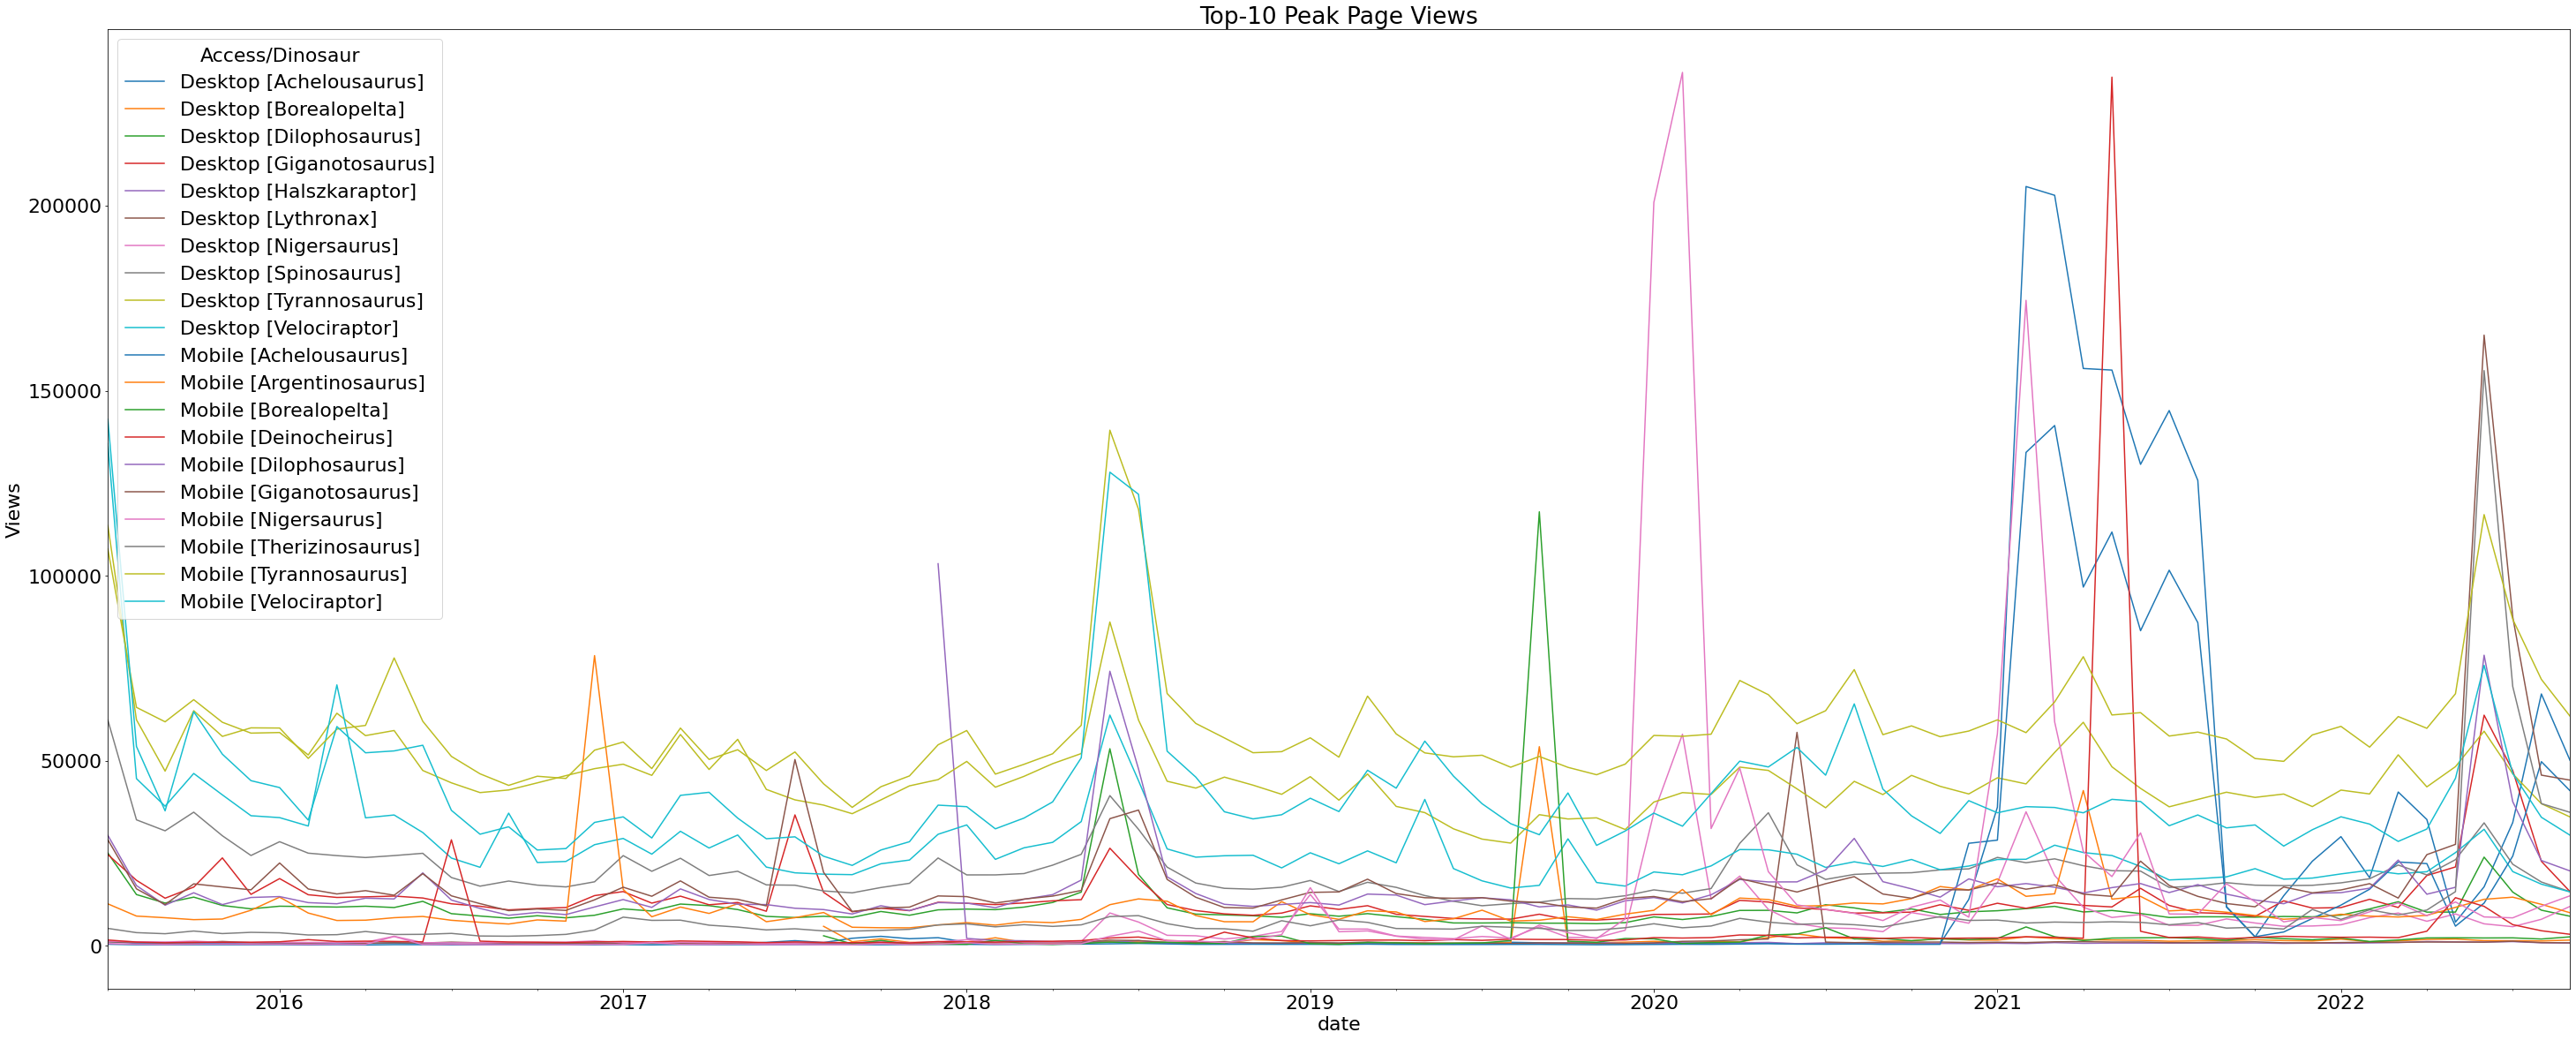

In [57]:
desktop_top10 = desktop_df[desktop_df['article'].isin(desktop_df.groupby('article')['views'].max().nlargest(10).index)]
desktop_top10['article'] = "Desktop [" + desktop_top10['article'] + "]"

mobile_top10 = mobile_df[mobile_df['article'].isin(mobile_df.groupby('article')['views'].max().nlargest(10).index)]
mobile_top10['article'] = "Mobile [" + mobile_top10['article'] + "]"

desktop_top10.set_index('date', inplace=True)
mobile_top10.set_index('date', inplace=True)

desktop_top10.groupby('article')['views'].plot(legend=True)
mobile_top10.groupby('article')['views'].plot(legend=True)

plt.ylabel("Views")
plt.title("Top-10 Peak Page Views")
plt.rcParams["figure.figsize"] = (50,20)
plt.rcParams.update({'font.size': 22})
plt.legend(loc='upper left', title='Access/Dinosaur')

plt.savefig("./pic/Top 10 Peak Page Views.png")

##### Fewest Months of Data
The third graph should show pages that have the fewest months of available data. These will all be relatively short time series, some may only have one month of data. Your graph should show the 10 articles with the fewest months of data for desktop access and the 10 articles with the fewest months of data for mobile access.

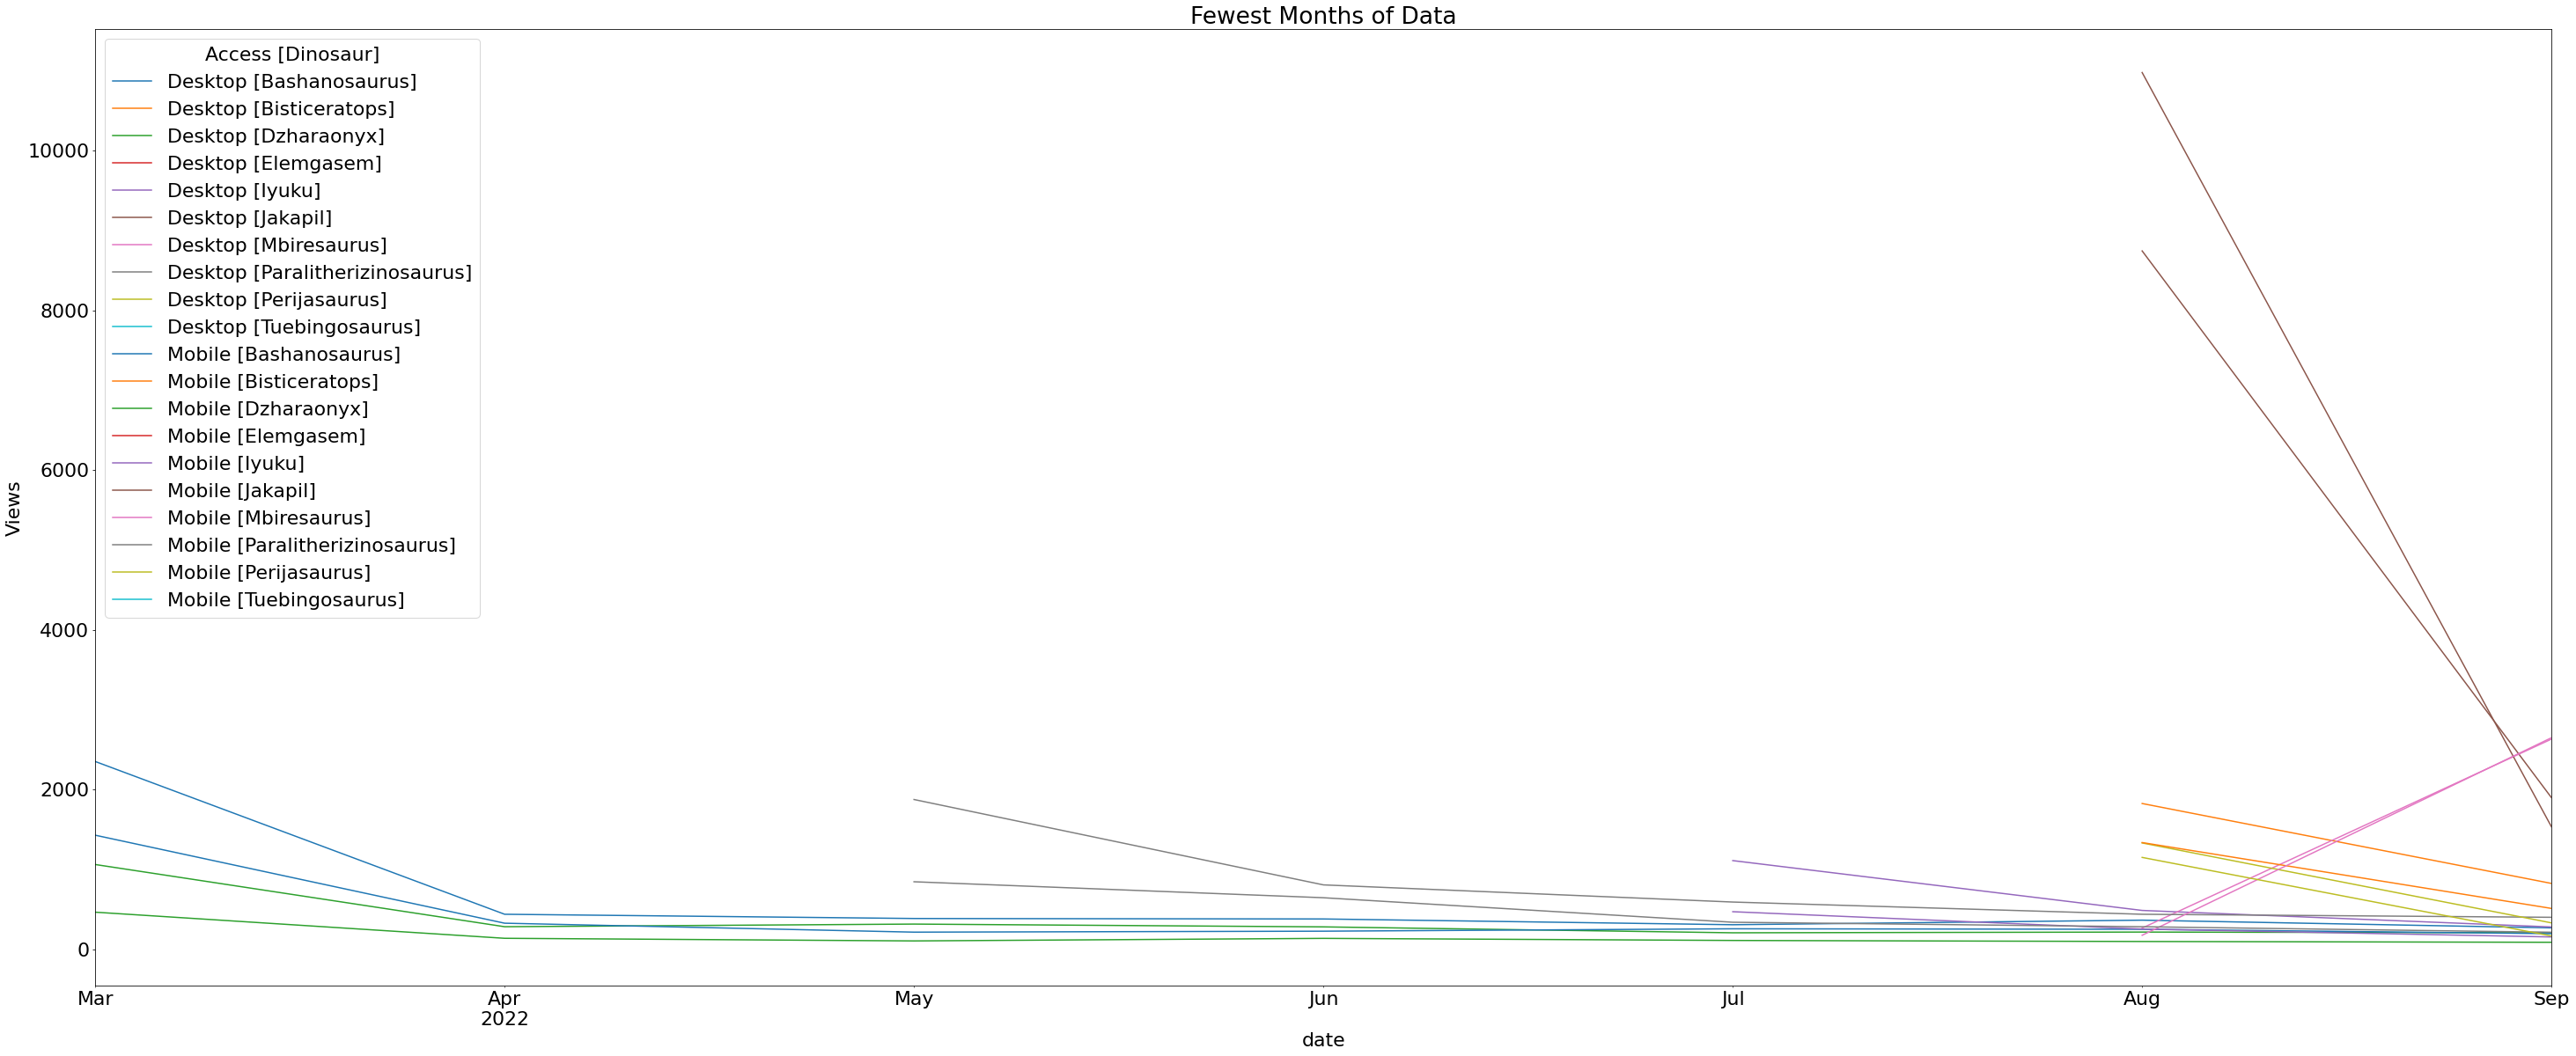

In [56]:
desktop_bottom10 = desktop_df[desktop_df['article'].isin(desktop_df.groupby('article').size().nsmallest(10).index)]
desktop_bottom10['article'] = "Desktop [" + desktop_bottom10['article'] + "]"

mobile_bottom10 = mobile_df[mobile_df['article'].isin(mobile_df.groupby('article').size().nsmallest(10).index)]
mobile_bottom10['article'] = "Mobile [" + mobile_bottom10['article'] + "]"

desktop_bottom10.set_index('date', inplace=True)
mobile_bottom10.set_index('date', inplace=True)

desktop_bottom10.groupby('article')['views'].plot(legend=True)
mobile_bottom10.groupby('article')['views'].plot(legend=True)

plt.ylabel("Views")
plt.title("Fewest Months of Data")
plt.legend(loc='upper left', title='Access [Dinosaur]')

plt.savefig("./pic/Fewest Months of Data.png")